## Question 1

In [1]:
import numpy as np
from qat.lang.AQASM import Program, H,  AbstractGate, QRoutine
from scipy import linalg # for linalg.expm, the matrix exponential.
from qat.qpus import get_default_qpu # numerical simulator for small quantum circuits.

prog = Program() 
q = prog.qalloc(2)

prog.apply(H, q[0])

def matrix(theta):
    X = np.array([[0,1],[1,0]])
    return linalg.expm(-1j * theta * X)

ham_x = AbstractGate("ham_X", [float], arity=1, matrix_generator=matrix) # definition of a custom parametrized gate

prog.apply(ham_x(0.3).ctrl(), q)

circ = prog.to_circ() # The program is exported into a circuit.  

# displaying the circuit:
%qatdisplay --svg circ



qpu = get_default_qpu()

job = circ.to_job()
result = qpu.submit(job)

for sample in result:
    # print results
    print(sample.state, sample.amplitude, sample.probability)

|00> (0.7071067811865475+0j) 0.4999999999999999
|10> (0.6755249097756644+0j) 0.4563339037274195
|11> -0.20896434210788314j 0.043666096272580425


### Hamiltonian data

The purpose of the TP is to reproduce, using numerical simulation, Figure 3.(a) of https://arxiv.org/abs/1512.06860.

On this figure, the ground state energy of a dihydrogen molecule is plotted against the distance $R$ separating the hydrogen atoms. It allows to predict the **equilibrium bond length** of the molecule.

*Note*: In more complicated settings with larger molecules, energy may be plotted against various distances and angles, forming an *energy landscape* that proves useful in predicting chemical reaction mechanisms, rates, etc.

The cell below imports the data of Table I of https://arxiv.org/abs/1512.06860.

In [2]:
#importing Hamiltonian data
import json 

with open('hamiltonian_data.json','r') as f:
    ham_data = json.load(f)
    
#for coeffs in ham_data:
#    print(coeffs)

### Question 2:
Implement QRoutines for each of the Hamiltonian evolutions we need.



In [3]:
from qat.lang.AQASM import CNOT, RZ, RX, RY, S, I
from tp_library_pea import U_II, U_ZI, U_IZ, U_ZZ, U_XX, U_YY
# TODO: implement U_II, U_ZI, U_IZ, U_ZZ, U_XX, U_YY in the file tp_library_pea.py
# JUPYTER TRICK: you might have to kernel -> restart and run all to see the effect here of your code edition.

test = False
if test:
    prog = Program()
    q = prog.qalloc(2)
    prog.apply(U_YY(3.), q)
    circ = prog.to_circ()

    %qatdisplay --svg circ

!python3 -m pytest tp_pea_question2_tests.py

============================= test session starts ==============================
platform linux -- Python 3.8.10, pytest-4.6.9, py-1.8.1, pluggy-0.13.0
rootdir: /home/thib/Desktop/Master/M2 Nano/Info quantique/TP_kit_phase_estimation
collected 5 items                                                              

tp_pea_question2_tests.py .....                                          [100%]

=============================== warnings summary ===============================
/usr/lib/python3/dist-packages/scipy/linalg/__init__.py:217
  /usr/lib/python3/dist-packages/scipy/linalg/__init__.py:217: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
    from numpy.dual import register_func

-- Docs: https://docs.pytest.org/en/latest/warnings.html
===================== 5 passed, 1 warnings in 0.27 seconds =====================


### Question 3:
Complete in 'tp_library_pea.py' the implementation of the function returning a Qroutine implementing a Trotterized evolution generated by our Hamiltonian.

In [4]:
from tp_library_pea import trotter_ham_simulation

!python3 -m pytest tp_pea_question3_tests.py

============================= test session starts ==============================
platform linux -- Python 3.8.10, pytest-4.6.9, py-1.8.1, pluggy-0.13.0
rootdir: /home/thib/Desktop/Master/M2 Nano/Info quantique/TP_kit_phase_estimation
collected 1 item                                                               

tp_pea_question3_tests.py .                                              [100%]

=============================== warnings summary ===============================
/usr/lib/python3/dist-packages/scipy/linalg/__init__.py:217
  /usr/lib/python3/dist-packages/scipy/linalg/__init__.py:217: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
    from numpy.dual import register_func

-- Docs: https://docs.pytest.org/en/latest/warnings.html
===================== 1 passed, 1 warnings in 0.24 seconds =====================


### Question 4: Implement iterative phase estimation
As a function taking as input an Hamiltonian and execution parameters, and returning a phase.

In [5]:
from tp_library_pea import compute_phi_k, perfect_ham_simulation
# perfect_ham_simulation: ideal, non-Trotterized simulation.

!python3 -m pytest tp_pea_question4_tests.py

============================= test session starts ==============================
platform linux -- Python 3.8.10, pytest-4.6.9, py-1.8.1, pluggy-0.13.0
rootdir: /home/thib/Desktop/Master/M2 Nano/Info quantique/TP_kit_phase_estimation
collected 1 item                                                               

tp_pea_question4_tests.py .                                              [100%]

=============================== warnings summary ===============================
/usr/lib/python3/dist-packages/scipy/linalg/__init__.py:217
  /usr/lib/python3/dist-packages/scipy/linalg/__init__.py:217: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
    from numpy.dual import register_func

-- Docs: https://docs.pytest.org/en/latest/warnings.html
===================== 1 passed, 1 warnings in 0.24 seconds =====================


In [14]:
from qat.lang.AQASM import X

E_max = 3
E_min = -2
    
dt = (2 * np.pi) / float(E_max)

def phase(coeffs, trotterization=False, trotter_number=4, shift=-E_min, nBits = 10):
    """
    Given Hamiltonian coefficients, compute phi, s.t U|\psi\rangle = e^{-2i\pi\phi}|\psi\rangle
    
    Args:
        - coeffs: a dictionary of coefficients as extracted from the list of dictionaries loaded
        from hamiltonian_data.json
        - trotterization: Boolean flag specifying whether to use the Trotterized evolution or the
        ideal "cheat mode" which exponentiates the Hamiltonian.
        - trotter_number: the "p" controlling the degree of approximation of the Trotterization.
        - shift: the energy shift that we use to make sure that the phase we compute is 0 < phi < 1
        
    Returns:
        - phi, a real number that should fall between 0 and 1.
    """
    
    bits = {}

    for k in range(nBits, 0, -1):
        
        # CIRCUIT CREATION
        prog = Program()

        q = prog.qalloc(3)

        prog.apply(H, q[0])

        # ansatz preparation, we are lucky it is so simple.
        prog.apply(X, q[1])

        # Trotterization
        if trotterization:
            prog.apply(trotter_ham_simulation(coeffs, (2**(k-1)) * dt, trotter_number, shift).ctrl(), q)
        else:
            prog.apply(perfect_ham_simulation(coeffs, (2**(k-1)) * dt, shift).ctrl(), q)

        phi_k = compute_phi_k(bits, nBits, k)

        # BEGIN IMPLEMENTATION. DO NOT MODIFY WHAT IS ABOVE.
        prog.apply(RZ(phi_k),q[0])
        prog.apply(H,q[0])
        # END IMPLEMENTATION. DO NOT MODIFY WHAT IS BELOW.
        
        circ = prog.to_circ()
                
        # CIRCUIT SIMULATION
        job = circ.to_job(qubits=[0])

        qpu = get_default_qpu()
        result = qpu.submit(job)

        # SELECTION OF MOST LIKELY RESULT 
        max_proba = -1
        max_state = -1
        for sample in result:
            if sample.probability > max_proba:
                max_proba = sample.probability
                max_state = sample.state.int
     
        bits[k] = max_state
          
    # recompute phi
    phi = 0
    for l in range(1,nBits+1,1):
        phi += float(bits[l])/float(2**l)
            
    return phi

### Plotting dissociation curves
Call the function you defined above to compute phases for each values of R. Convert them back to energies, and plot the result for two different Trotter number values: 4 and 10. Both should be wiggly approximations to the ideal curve, but 10 should be closer to it.

In [15]:
vals_perfect = []
vals_trotter_4 = []
vals_trotter_10 = []
Rs = []

shift = -E_min

for coeffs in ham_data:
    phi_perfect = phase(coeffs)
    phi_trotter_4 = phase(coeffs, trotterization=True, trotter_number=4)
    phi_trotter_10 = phase(coeffs, trotterization=True, trotter_number=10)

    # CONVERT PHASES BACK TO ENERGY
    E = ((2*np.pi)/dt)*phi_perfect - shift
    E_trotter_4 = ((2*np.pi)/dt)*phi_trotter_4 - shift 
    E_trotter_10 = ((2*np.pi)/dt)*phi_trotter_10 -shift

    
    print("R", coeffs['R'])
    Rs.append(coeffs['R'])
    
    vals_perfect.append(E)
    vals_trotter_4.append(E_trotter_4)
    vals_trotter_10.append(E_trotter_10)


R 0.2
R 0.25
R 0.3
R 0.35
R 0.4
R 0.45
R 0.5
R 0.55
R 0.6
R 0.65
R 0.7
R 0.75
R 0.8
R 0.85
R 0.9
R 0.95
R 1.0
R 1.05
R 1.1
R 1.15
R 1.2
R 1.25
R 1.3
R 1.35
R 1.4
R 1.45
R 1.5
R 1.55
R 1.6
R 1.65
R 1.7
R 1.75
R 1.8
R 1.85
R 1.9
R 1.95
R 2.0
R 2.05
R 2.1
R 2.15
R 2.2
R 2.25
R 2.3
R 2.35
R 2.4
R 2.45
R 2.5
R 2.55
R 2.6
R 2.65
R 2.7
R 2.75
R 2.8
R 2.85


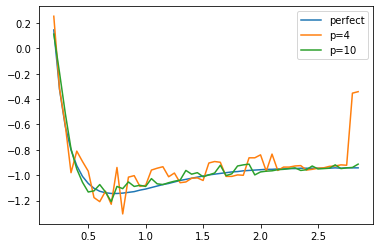

In [16]:
import matplotlib.pylab as plt

plt.plot(Rs, vals_perfect, label="perfect")
plt.plot(Rs, vals_trotter_4, label="p=4")
plt.plot(Rs, vals_trotter_10, label="p=10")
plt.legend()